In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio
import pickle
import time
import pprint
from tqdm import tqdm
import multiprocessing
from sympy import Symbol, sin, cos, tan, nsimplify
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
from optical_bloch_test.utils.general import flatten
from optical_bloch_test import Hamiltonian, Dissipator, BlochEquations
from multi_helper_funcs import multi_solve_ode, multi_solve_ode_integrate_excited


from julia import Main
from sympy import MutableDenseMatrix, conjugate, Function, Symbol

Define constants

In [2]:
hbar=1.054*1E-34; #[Js]
k_b=1.381*1E-23; #[J/K]
c=299792000; #[m/s]
eps_0=8.854*1E-12; #[F/m]
a0=5.29*1E-11; #[m]
q_e=1.602*1E-19; #[C]
Bohr_mag=1.39962449/1000*2*np.pi; #[GHz/G]

nground = 3
nexcite = 1
ntotal = 4

Import Rabi Matrix Elements that are calculated by the MatLab code. Other simple toy models are also put into the folder, please refer to them as needed.

In [3]:
rabi_matrix = np.zeros([ntotal,ntotal,3])
rabi_matrix[:,:,0] = np.genfromtxt('rabimatrix31toy1.csv',delimiter=',')
rabi_matrix[:,:,1] = np.genfromtxt('rabimatrix31toy2.csv',delimiter=',')
rabi_matrix[:,:,2] = np.genfromtxt('rabimatrix31toy3.csv',delimiter=',')

Define symbols for the Hamiltonian

In [4]:
E0 = Symbol(u'E0', real = True)
Ee = Symbol(u'Ee', real = True)

ω = Symbol(u'ω', real = True)
Ω = Symbol(u'Ω', real = True)
Δ = Symbol(u'Δ', real = True)
g = Symbol(u'g', real = True)

θ = Symbol(u'θ', real = True)
B = Symbol(u'B', real = True)

Initialize Hamiltonian

In [5]:
ham = Hamiltonian(ntotal)
ham.addEnergies([E0-g*B,E0,E0+g*B,Ee])

Add coupling between states

In [6]:
for i in range(nground):
    for j in range(nground, ntotal):
        if rabi_matrix[i, j, 0] != 0:
            prefactor = (-1)/np.sqrt(2)*sin(θ)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,0], ω)
        if rabi_matrix[i, j, 1] != 0:
            prefactor = (1)*cos(θ)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,1], ω)
        if rabi_matrix[i, j, 2] != 0:
            prefactor = (1)/np.sqrt(2)*sin(θ)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,2], ω)

Perform unitary transformation to remove the time dependence on the off diagonal term, and goes into the dress state

In [7]:
ham.eqnTransform()
ham.defineZero(Ee)
ham.defineEnergyDetuning(E0, Ee, Δ, ω)

In [8]:
ham.hamiltonian

Matrix([
[                                  -B*g + E0,                                          0,                                          0, -0.117851130197758*Ω*exp(1.0*I*t*ω)*sin(θ)],
[                                          0,                                         E0,                                          0,  0.166666666666666*Ω*exp(1.0*I*t*ω)*cos(θ)],
[                                          0,                                          0,                                   B*g + E0,  0.117851130197758*Ω*exp(1.0*I*t*ω)*sin(θ)],
[-0.117851130197758*Ω*exp(-1.0*I*t*ω)*sin(θ), 0.166666666666666*Ω*exp(-1.0*I*t*ω)*cos(θ), 0.117851130197758*Ω*exp(-1.0*I*t*ω)*sin(θ),                                         Ee]])

In [9]:
ham.transformed

Matrix([
[               -B*g - 1.0*Δ,                          0,                          0, -0.117851130197758*Ω*sin(θ)],
[                          0,                     -1.0*Δ,                          0,  0.166666666666666*Ω*cos(θ)],
[                          0,                          0,                B*g - 1.0*Δ,  0.117851130197758*Ω*sin(θ)],
[-0.117851130197758*Ω*sin(θ), 0.166666666666666*Ω*cos(θ), 0.117851130197758*Ω*sin(θ),                           0]])

Calculate transition strength with rabi matrix elements define before

In [10]:
transition_strengths=np.zeros([ntotal,ntotal]);
for i in range(ntotal):
    for f in range(ntotal):
        for p in range(3):
            transition_strengths[i,f]=transition_strengths[i,f]+rabi_matrix[i,f,p]**2

Use transition strength to calculate the Branching Ratios from excited states to ground states

In [11]:
BR = np.zeros([ntotal, ntotal])
for i in range(ntotal):
    sums=0
    for f in range(ntotal):
        sums=sums+transition_strengths[i,f]
        
    for f in range(ntotal):
        BR[i,f]=transition_strengths[i,f]/sums
        
for i in range(nground):
    BR[i,:]=0

In [12]:
BR[nground:,:]

array([[0.33333333, 0.33333333, 0.33333333, 0.        ]])

Use the BR to build dissipator in the Master equation

In [13]:
Γ = Symbol(u'Γ', real = True)
dis = Dissipator(ntotal)

for exct in tqdm(range(nground, ntotal)):
    for grnd in range(nground):
        if BR[exct, grnd] != 0:
            dis.addDecay(exct, grnd, Γ * BR[exct, grnd])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.71it/s]


In [14]:
dis.dissipator

Matrix([
[0.333333333333333*Γ*ρ₃₃(t),                          0,                          0, -0.5*Γ*ρ₀₃(t)],
[                         0, 0.333333333333333*Γ*ρ₃₃(t),                          0, -0.5*Γ*ρ₁₃(t)],
[                         0,                          0, 0.333333333333333*Γ*ρ₃₃(t), -0.5*Γ*ρ₂₃(t)],
[  -0.5*Γ*conjugate(ρ₀₃(t)),   -0.5*Γ*conjugate(ρ₁₃(t)),   -0.5*Γ*conjugate(ρ₂₃(t)), -1.0*Γ*ρ₃₃(t)]])

Build the bloch equations

In [15]:
%%time
bloch = BlochEquations(ntotal, dis.density_matrix, ham.transformed, dis.dissipator)

start generateEquations
start generateSteadyStateDensityMatrix
start generateEquationsSteadyState
Wall time: 855 ms


You can use Python to solve the Bloch equation. The speed is limited when the system gets heavier but can be useful when the system is small.
If you want to use Julia, you can skip this section and directly go to Julia module.

Here you can define the numerical values and put them into the well-established Bloch equations, and numerically solve them.

In [16]:
y0 = np.zeros([ntotal, ntotal], dtype = complex)
y0[0,0] = 1/3
y0[1,1] = 1/3
y0[2,2] = 1/3
y0 = y0.flatten()

In [18]:
Γ_val = 1
replacements = [(Δ, 0),
                (Ω, np.sqrt(3/2)*Γ_val),
                (Δ, 0*Γ_val),
                (θ, 60/180*np.pi),
                (B, 0.1),
                (g, 1),
                (Γ, Γ_val)]

In [19]:
%%time
sol = bloch.solveNumeric(replacements, [0,300], y0, method = 'BDF')

Wall time: 1.1 s


It's been calculated! The results are plotted below.

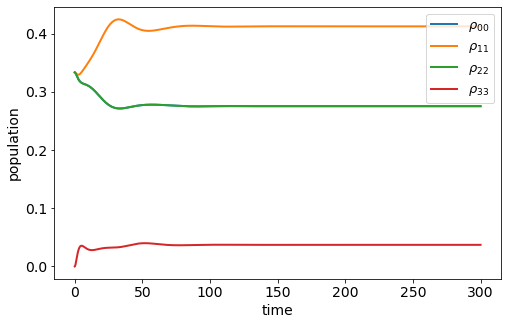

In [20]:
r = np.einsum("iij->ij", sol.y.reshape(4,4,sol.t.size)).real

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(sol.t, r[0], label = r'$\rho_{00}$', lw = 2)
ax.plot(sol.t, r[1], label = r'$\rho_{11}$', lw = 2)
ax.plot(sol.t, r[2], label = r'$\rho_{22}$', lw = 2)
ax.plot(sol.t, r[3], label = r'$\rho_{33}$', lw = 2)

ax.legend(fontsize = 13)
ax.set_xlabel('time')
ax.set_ylabel('population')

set_fontsize(ax, 14)

Here is how you can use Julia to do way faster calculations. Again, Julia is faster only when you have more comlicated (like 8level or 16levels system)and large amount of parallel calculation, otherwise you might not feel the difference.

If it's the first time you run Julia in your machine, you might need to download Julia and a bunch of packages to use. If you cannot use Julia, don't forget to install PyJulia.

In [32]:
from julia import Main

In [33]:
nprocs = 3 # number of processes to use for EnsembleDistributed 
Main.eval(f"""
using BenchmarkTools
using Distributed
""")

if Main.eval("nprocs()") < nprocs:
    Main.eval(f"addprocs({nprocs}-nprocs())")

if Main.eval("nprocs()") > nprocs:
    addprocs({nprocs})
    procs = Main.eval("procs()")
    procs = procs[nprocs:]
    Main.eval(f"rmprocs({procs})")

Main.eval("""
@everywhere begin
    using ModelingToolkit
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    using ModelingToolkit
end
""")
    
Main.eval("procs()")

array([1, 2, 3], dtype=int64)

Above you set the number of processors you want to use. It's better to be smaller than the total logical processors number of your device.
Below is to introduce the hamiltonian and dissipators into Julia, and build the equations in Julia.

In [34]:
from sympy import MutableDenseMatrix, conjugate, Function, Symbol

t = Symbol('t', real = True)

hamiltonian_symbols = ham.transformed.free_symbols
dissipator_symbols = dis.dissipator.free_symbols
dissipator_symbols = set([d for d in dissipator_symbols if str(d)[0] not in ['ρ', 't']])

for s in list(hamiltonian_symbols) + list(dissipator_symbols):
    Main.eval(f"""
                @everywhere @parameters {str(s)}
                tmp = 0
            """);


lx, ly = ham.transformed.shape
Main.eval(f"""
            @everywhere begin
            H = zeros(Num, {lx}, {ly})
            L = zeros(Num, {lx}, {ly})
            @variables t ρ[1:{lx},1:{ly}](t)
            @parameters icomplex
            D = Differential(t)
            tmp = 0
            end
            """);

# the code below is to transform the symbolic version of Sympy into a form usable with Julia
diss = MutableDenseMatrix(dis.dissipator.copy())

for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(j+1, i+1))
        diss = diss.subs(conjugate(tmp(t)), tmp1(t))
            
for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(i+1, j+1))
        diss = diss.subs(tmp(t), tmp1(t))


# Creating the Hamiltonian matrix and Dissipator matrix in Julia
for idx in range(1,lx+1):
    for idy in range(1,ly+1):
        hval = str(ham.transformed[idx-1,idy-1])
        dval = str(diss[idx-1, idy-1])
        dval = dval.replace('(t)', '')
        Main.eval(f"""
                @everywhere begin
                H[{idx},{idy}] = {hval}
                L[{idx},{idy}] = {dval}
                tmp = 0
                end
                """);
        
# ham_pars = ham.transformed.free_symbols

In [36]:
# Creating the system of equations
ham_string = ','.join([str(h) for h in hamiltonian_symbols])
diss_string = ','.join([str(d) for d in dissipator_symbols])

Main.eval(f"""
@everywhere begin
    eq = -icomplex*Symbolics.scalarize(H*ρ-ρ*H) + L
    eqns = [D(ρ[idx,idy]) ~ eq[idx,idy] for idx in 1:{lx} for idy in 1:{ly}];
    @named bloch = ODESystem(eqns)
    tmp = 0
end
""");

In [37]:
# initial populations
y0 = np.zeros([ham.levels, ham.levels], dtype = complex)
for _ in range(3):
    y0[_,_] = 1/3
Main.ρ_ini = y0
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [38]:
print(hamiltonian_symbols,dissipator_symbols)

{θ, Ω, Δ, B, g} {Γ}


In [39]:
# setting up the parameters of the model and initial conditions
Main.eval("""
    @everywhere begin
    p = [
    Δ => 0,
    Ω => sqrt(3/2)*3/5*1,
    θ => 60/180*π,
    B => 0.1,
    g => 1,
    Γ => 1,
    icomplex => im
    ]
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:size(ρ_ini)[1] for idy in 1:size(ρ_ini)[1]]
    tmp =0;
end
""");

In [40]:
# creating the problem to solve
Main.eval("""
@everywhere begin
    tspan = (0.0, 1000.)
    prob = ODEProblem(bloch, ρ_ini, tspan, p, jac = true)
end
""");

In [41]:
# solving the ODEProblem, keep in mind that the first run compiles called functions
# the first run will be significantly slower (due to compilation), but any subsequent solves are fast
Main.eval("@time sol = solve(prob, Tsit5(), abstol = 1e-10, reltol = 1e-10)");

In [42]:
ut = np.array(Main.eval("sol[:]"))
dim = int(np.sqrt(ut.shape[1]))
pop_results = np.real(np.einsum('jji->ji',ut.reshape(-1,dim, dim).T))
t_array = Main.eval("sol.t") 

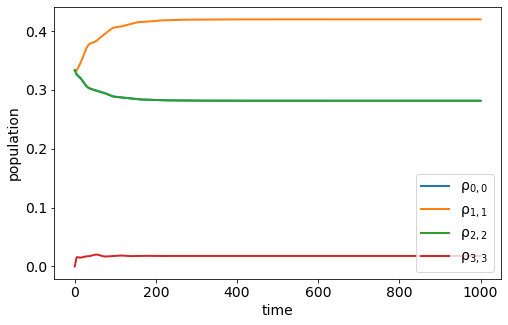

In [43]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

If you want to calculate the force in the system, you could move to the file called "3+1 toy system with force calculation" where the hamiltonian is defined properly.